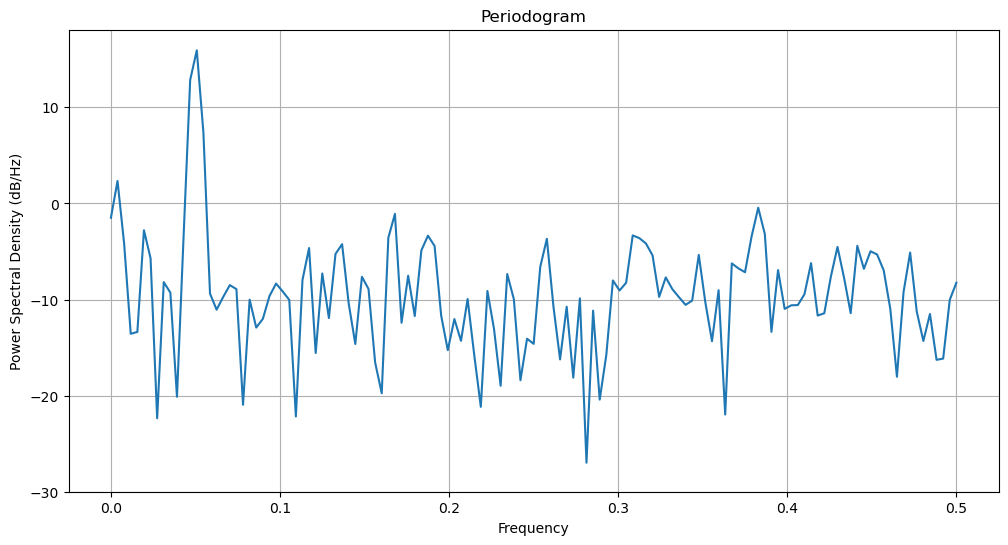

Data is non-stationary. Differencing...


C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fore

Best ARMA order: (3, 2) with AIC: 388.9707335476258


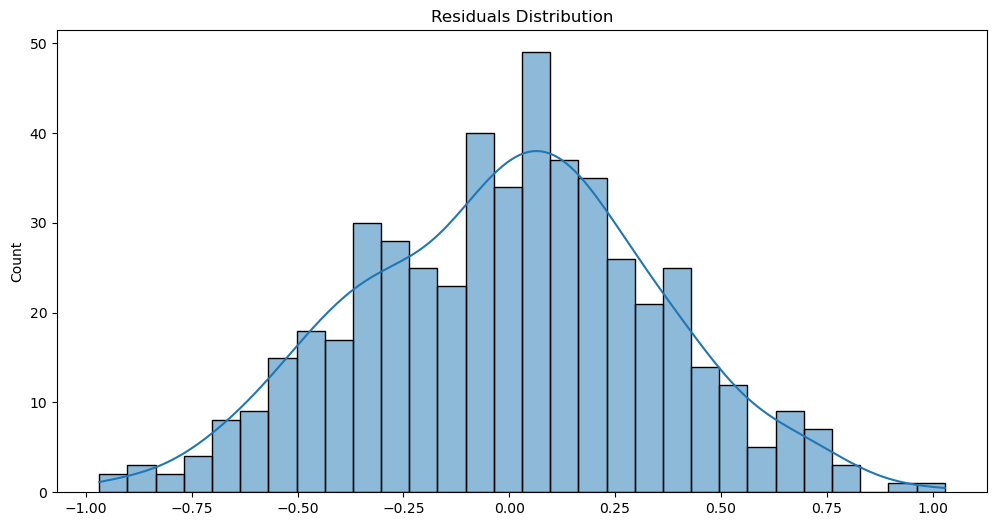

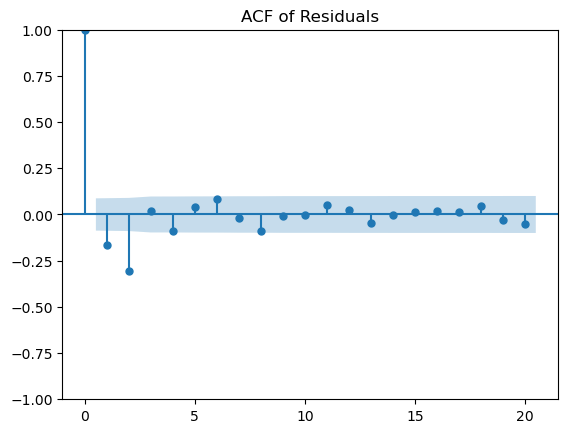

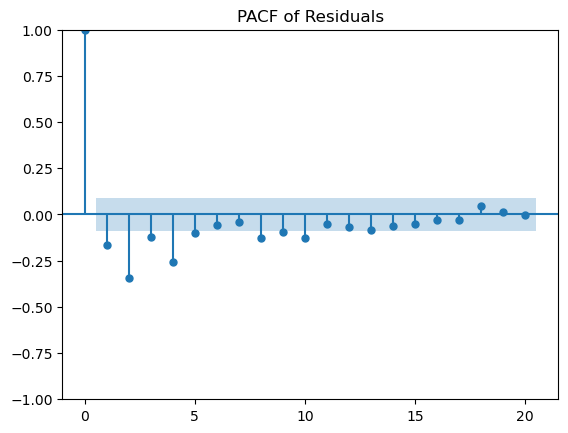

ADF test on residuals: p-value = 3.17814389002115e-18
Residuals are stationary and resemble white noise.
Forecast for 2025-02-23: mean=-0.03045676952369547, std error=0.34487540567477754
Predicted value for 2025-02-23: -0.3215981175236955
Predicted Value (pt+1): -0.3215981175236955
Expected Payoffs:
up: 0.3048
down: -0.3048
in_range: -0.6355
out_range: 0.6355


C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\perci\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
import seaborn as sns

# Step 1: Load and preprocess the data
def load_and_preprocess(data_path):
    # Load the dataset
    data = pd.read_csv('olga.csv')  
    log_prices = data['Value']  # Ensure 'value' column exists

    # Check for seasonality
    plt.figure(figsize=(12, 6))
    plt.psd(log_prices, NFFT=256, Fs=1, detrend='mean')
    plt.title("Periodogram")
    plt.show()

    # Check for stationarity
    result = adfuller(log_prices)
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing...")
        log_prices_diff = log_prices.diff().dropna()
    else:
        print("Data is stationary.")
        log_prices_diff = log_prices

    return log_prices, log_prices_diff

# Step 2: Fit optimal ARMA(p, q)
def fit_arma(log_prices_diff):
    best_aic = np.inf
    best_order = None
    best_model = None


    # Search for the best ARMA(p, q)
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(log_prices_diff, order=(p, 0, q)).fit()
                aic = model.aic
                bic = model.bic
                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_order = (p, q)
                    best_model = model
            except Exception as e:
                continue

    print(f"Best ARMA order: {best_order} with AIC: {best_aic}")

    # Analyze residuals
    residuals = best_model.resid
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title("Residuals Distribution")
    plt.show()

    plot_acf(residuals, lags=20)
    plt.title("ACF of Residuals")
    plt.show()

    plot_pacf(residuals, lags=20)
    plt.title("PACF of Residuals")
    plt.show()

    # Check if residuals resemble white noise
    adf_test = adfuller(residuals)
    print(f"ADF test on residuals: p-value = {adf_test[1]}")
    if adf_test[1] <= 0.05:
        print("Residuals are stationary and resemble white noise.")
    else:
        print("Residuals may not be white noise.")

    return best_model

# Step 3: Forecast future values
def forecast_next_step(model, last_value, target_date):
    forecast = model.get_forecast(steps=1)
    forecast_mean = forecast.predicted_mean.iloc[0]
    forecast_se = np.sqrt(forecast.var_pred_mean.iloc[0])

    # Compute the predicted value
    predicted_value = last_value + forecast_mean

    print(f"Forecast for {target_date}: mean={forecast_mean}, std error={forecast_se}")
    print(f"Predicted value for {target_date}: {predicted_value}")

    return forecast_mean, forecast_se, predicted_value

# Step 4: Betting logic
def calculate_bet_probabilities(forecast_mean, forecast_se):
    up_prob = 1 - norm.cdf(0, loc=forecast_mean, scale=forecast_se)
    down_prob = norm.cdf(0, loc=forecast_mean, scale=forecast_se)
    in_range_prob = norm.cdf(-0.29, loc=forecast_mean, scale=forecast_se) - norm.cdf(-0.49, loc=forecast_mean, scale=forecast_se)
    out_range_prob = 1 - in_range_prob

    print(f"Up bet probability: {up_prob:.4f}")
    print(f"Down bet probability: {down_prob:.4f}")
    print(f"In-range bet probability: {in_range_prob:.4f}")
    print(f"Out-of-range bet probability: {out_range_prob:.4f}")

    return up_prob, down_prob, in_range_prob, out_range_prob

# Step 5: Evaluate profitability
def evaluate_bets(bet_prices, probabilities):
    expected_payoffs = {}

    for bet, price in bet_prices.items():
        expected_payoffs[bet] = probabilities[bet] - price

    print("Expected Payoffs:")
    for bet, payoff in expected_payoffs.items():
        print(f"{bet}: {payoff:.4f}")

    return expected_payoffs

# Main function to execute all steps
def main():
    data_path = 'olga.csv'  

    # Step 1
    log_prices, log_prices_diff = load_and_preprocess(data_path)

    # Step 2
    best_model = fit_arma(log_prices_diff)

    # Step 3
    last_value = log_prices.iloc[-1]
    target_date = "2025-02-23"
    forecast_mean, forecast_se, predicted_value = forecast_next_step(best_model, last_value, target_date)

    # Step 4
    bet_prices = {
        'up': 0.16,
        'down': 0.84,
        'in_range': 0.77,
        'out_range': 0.23
    }

    probabilities = {
        'up': 1 - norm.cdf(0, loc=forecast_mean, scale=forecast_se),
        'down': norm.cdf(0, loc=forecast_mean, scale=forecast_se),
        'in_range': norm.cdf(-0.29, loc=forecast_mean, scale=forecast_se) - norm.cdf(-0.49, loc=forecast_mean, scale=forecast_se),
        'out_range': 1 - (norm.cdf(-0.29, loc=forecast_mean, scale=forecast_se) - norm.cdf(-0.49, loc=forecast_mean, scale=forecast_se))
    }

    # predicted value
    print(f"Predicted Value (pt+1): {predicted_value}")
    
    # Step 5
    evaluate_bets(bet_prices, probabilities)

if __name__ == "__main__":
    main()
